In [51]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import sys
sys.path.append("../")

import FlightPhaseTools as fpt
from ResearchFlight import ResearchFlight
from ResearchFlightSegment import ResearchFlightSegment

# Load data into xarray datasets

In [52]:
outdir = '../flight_phase_files/'
datadir = '/Users/heike/Documents/eurec4a/data_processing/EUREC4A_campaignData/all_nc/'
bahamas = xr.open_dataset(datadir + 'bahamas_20200119_v0.4.nc')
dropsondes = xr.open_dataset(datadir + 'dropsondes_20200119_v0.4.nc')

# Determine the timestamps of the different flight phases using the FlightPhaseTools module.

In [53]:
takeoff = 0
touchdown = len(bahamas['time']) - 1

# Radar calibration
# ntas_dropsonde = fpt.ds_timestamp_ind(bahamas, dropsondes, 0)
# bahamas["altitude_dt"] = (['time'], np.append(np.diff(bahamas["altitude"]),0))
# min_dh_dt_before_radar_cal = fpt.find_first_value_before_ts_ind(bahamas, 'altitude_dt', 
#                                                                 ntas_dropsonde, -8., 0.5)
# radar_cal_wiggle_min_roll = fpt.find_first_value_after_ts_ind(bahamas, 'roll', min_dh_dt_before_radar_cal, 
#                                                               -10., 0.5)
# enter_radar_cal_wiggle = fpt.find_first_value_before_ts_ind(bahamas, 'altitude_dt', 
#                                                             radar_cal_wiggle_min_roll, 0., 0.05)
# radar_cal_wiggle_max_roll = fpt.find_first_value_before_ts_ind(bahamas, 'roll', ntas_dropsonde, 20., 0.5)
# exit_radar_cal_wiggle = fpt.find_first_value_after_ts_ind(bahamas, 'roll', radar_cal_wiggle_max_roll, 0., 0.05)

ntas_dropsonde = fpt.ds_timestamp_ind(bahamas, dropsondes, 0)

# Radar wiggle new

max_roll_for_radar = fpt.max_timestamp_ind(bahamas, 'roll', 
                      slice('2020-01-19T16:00:00', '2020-01-19T16:10:00'), order=1000)
enter_radar_cal_wiggle = fpt.find_first_value_before_ts_ind(bahamas, 'roll', 
                                                            max_roll_for_radar, 0., 0.05)
second_max_roll_for_radar = fpt.max_timestamp_ind(bahamas, 'roll', 
                      slice('2020-01-19T16:10:00', '2020-01-19T16:15:00'), order=1000)
exit_radar_cal_wiggle = fpt.find_first_value_after_ts_ind(bahamas, 'roll', 
                                                            second_max_roll_for_radar, 0., 0.5)

In [54]:
# Super curtain
supercurtain_dropsonde = fpt.ds_timestamp_ind(bahamas, dropsondes, 1)
circle_center_dropsonde = fpt.ds_timestamp_ind(bahamas, dropsondes, 2)

# Circle 1
c1_first_dropsonde = fpt.ds_timestamp_ind(bahamas, dropsondes, 3)
enter_c1 = c1_first_dropsonde-2
exit_c1 = fpt.exit_circle_timestamp_ind(bahamas, enter_c1)

# Circling 1
enter_circling = enter_c1
max_roll_after_circling = fpt.min_timestamp_ind(bahamas, 'roll', 
                      slice('2020-01-19T18:15:00', '2020-01-19T18:30:00'), order=1000)
exit_circling = fpt.find_first_value_before_ts_ind(bahamas, 'roll', max_roll_after_circling, 3., 0.05)

## Fill these lists with the flight timestamp indices you would like to display on the BAHAMAS plots, with corresponding labels. 

In [55]:
ts_ind_list = [takeoff, ntas_dropsonde, enter_radar_cal_wiggle, 
               exit_radar_cal_wiggle, supercurtain_dropsonde, 
               circle_center_dropsonde, enter_c1, c1_first_dropsonde, exit_c1, touchdown, 
               max_roll_after_circling, max_roll_for_radar]
label_list = ["takeoff", "ntas_dropsonde", "enter_radar_cal_wiggle", 
              "exit_radar_cal_wiggle", "supercurtain_dropsonde", 
              "circle_center_dropsonde", "enter_c1", "c1_first_dropsonde", "exit_c1", "touchdown", 
              "max_roll_after_circling", "max_roll_for_radar"]

In [56]:
#create markers for every dropsonde
#--> helps to see the individual circles
#only execute if needed!
# ts_ind_list = []
# label_list = np.arange(1, len(dropsondes["launch_time"])+1)
# for i in range(len(dropsondes["launch_time"])):
#     ts_ind_list.append(fpt.ds_timestamp_ind(bahamas, dropsondes,  i))

# Check numer of good dropsondes per circle

In [57]:
c1NumSondes = 0
for i in range(len(dropsondes["launch_time"])):
    if fpt.dt64_to_dt(bahamas["time"][enter_c1].values) \
    < fpt.dt64_to_dt(dropsondes["launch_time"][i].values) \
    < fpt.dt64_to_dt(bahamas["time"][exit_c1].values):
        c1NumSondes = c1NumSondes+1


# Create basic timeseries of bahamas data with markers for determined timestamps to manually evaluate the validity of the timestamps.

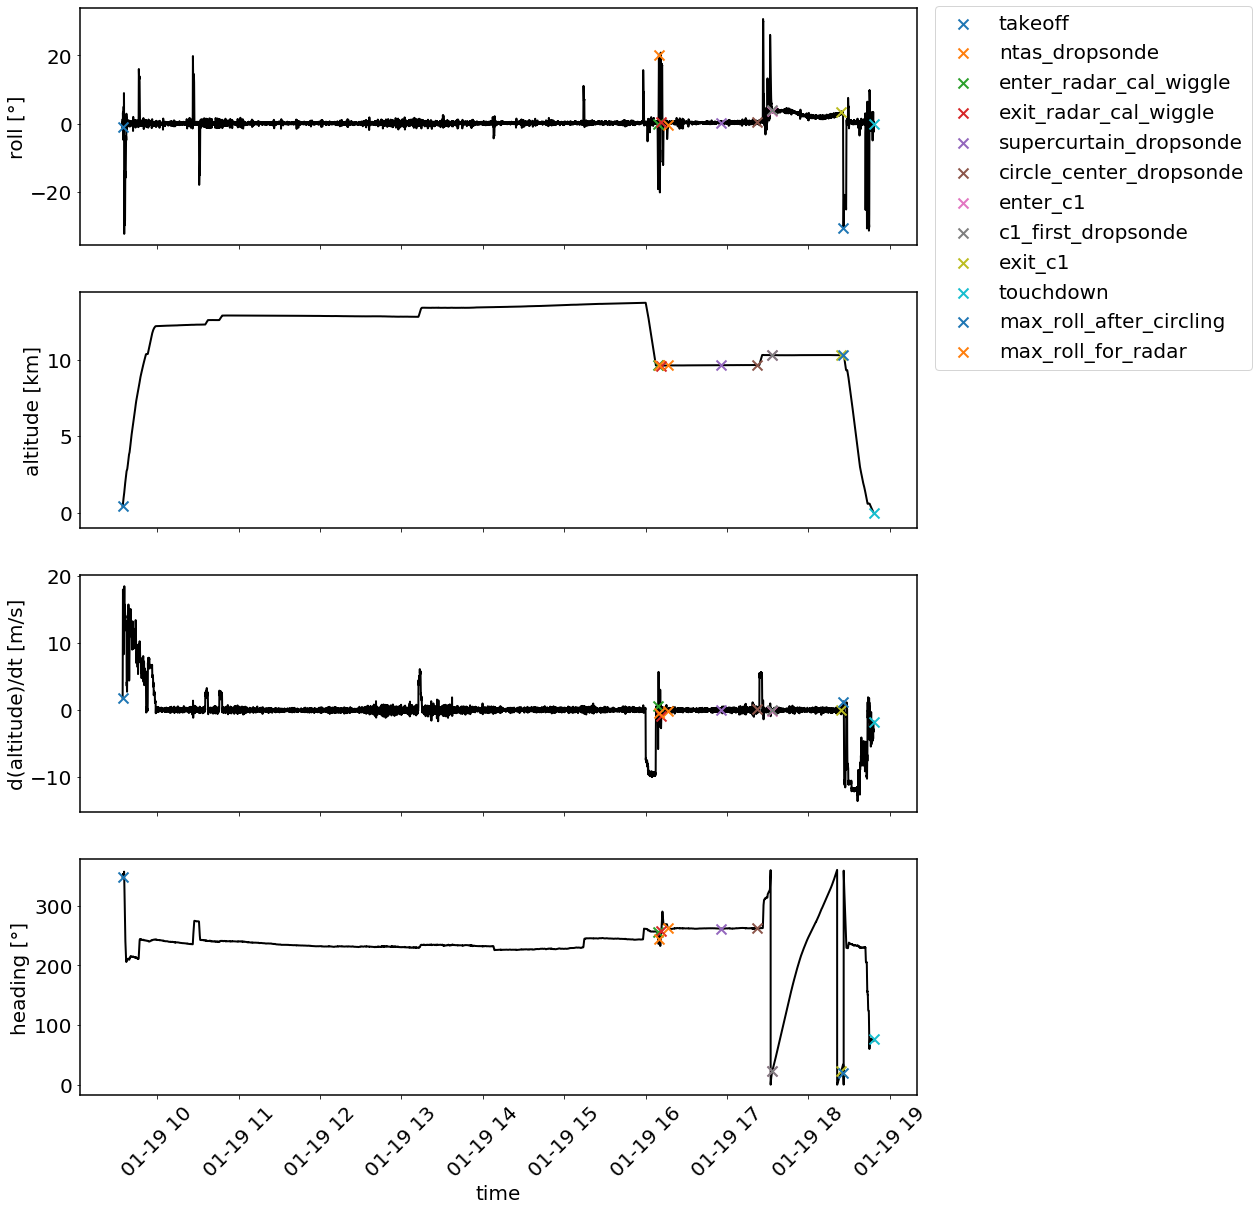

In [58]:
fig, ax = fpt.plot_bahamas_timeseries(bahamas, ts_ind_list, label_list)

# Create a ResearchFlight object to represent the general flight meta data.

In [59]:
RF01 = ResearchFlight(name=f"RF{bahamas.attrs['flight_number']}",
                      mission=bahamas.attrs['mission'],
                      flight_id='HALO-0119',
                      contacts=[
                          {
                              'name': 'Marc Prange', 
                              'email': 'marc.prange@uni-hamburg.de',
                              'tags': ['dataset creator'],
                          },
                          {
                              'name': 'Silke Gross',
                              'email': 'silke.gross@dlr.de',
                              'tags': ['flight PI']
                          }
                      ],
                      date=fpt.dt64_to_dt(bahamas['time'][takeoff].values).date(),
                      flight_report='https://observations.ipsl.fr/aeris/eurec4a-data/REPORTS/HALO/2020/20200119/HALO-0119.pdf',
                      takeoff=fpt.dt64_to_dt(bahamas['time'][takeoff].values),
                      landing=fpt.dt64_to_dt(bahamas['time'][touchdown].values),
                      events=[{'name': 'NTAS overpass with dropsonde',
                               'time': fpt.dt64_to_dt(bahamas["time"][ntas_dropsonde].values)},
                              {'name': 'ship overpass with dropsonde',
                               'time': fpt.dt64_to_dt(bahamas["time"][supercurtain_dropsonde].values)},
                              {'name': 'circle center dropsonde',
                               'time': fpt.dt64_to_dt(bahamas["time"][circle_center_dropsonde].values)}
                              ],
                      remarks=['Transfer flight to Barbados.',
                               'Clear sky during take off in Santiago de Compostela.',
                               'Super curtain from NTAS buoy over ships towards circle center.'
                               ],
)

# Store the flight phase information in ResearchFlightSegment objects.

In [60]:
radar_cal_wiggle = ResearchFlightSegment(kinds=['radar_calibration_wiggle'],
                                name='Radar calibration with +-20 deg roll wiggles',
                                irregularities=[],
                                segment_id=RF01.flight_id + '_rcw1',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_radar_cal_wiggle].values),
                                end=fpt.dt64_to_dt(bahamas["time"][exit_radar_cal_wiggle].values)
                               )
supercurtain = ResearchFlightSegment(kinds=['straight_leg', 'super_curtain'],
                                name='Super curtain (from NTAS, over ships, to circle center)',
                                irregularities=[],
                                segment_id=RF01.flight_id + '_sl1',
                                start=fpt.dt64_to_dt(bahamas["time"][supercurtain_dropsonde].values),
                                end=fpt.dt64_to_dt(bahamas["time"][circle_center_dropsonde].values)
                               )
circle1 = ResearchFlightSegment(kinds=['circle'],
                                name='Circle 1',
                                good_dropsondes=c1NumSondes,
                                irregularities=['Start of circle directly with first drop, roll angle around 4 deg in beginning'],
                                segment_id=RF01.flight_id + '_c1',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c1].values),
                                end=fpt.dt64_to_dt(bahamas["time"][exit_c1].values)
                               )
circling1 = ResearchFlightSegment(kinds=['circling'],
                                  name='Circling',
                                  irregularities=['Start of circling directly with first drop'],
                                  good_dropsondes=c1NumSondes,
                                  segment_id=RF01.flight_id + '_o1',
                                  start=fpt.dt64_to_dt(bahamas["time"][enter_circling].values),
                                  end=fpt.dt64_to_dt(bahamas["time"][exit_circling].values)
                                 )

## Append the ResearchFlightSegment objects to the ResearchFlight object.

In [61]:
RF01.append_segments([radar_cal_wiggle,
                      supercurtain, 
                      circle1, circling1])

## You can look at the ResearchFlight Object as a dictionary, which is also the shape in which it will be stored as a YAML file.

In [62]:
RF01.to_dictionary()

{'name': 'RF01',
 'mission': 'EUREC4A',
 'flight_id': 'HALO-0119',
 'contacts': [{'name': 'Marc Prange',
   'email': 'marc.prange@uni-hamburg.de',
   'tags': ['dataset creator']},
  {'name': 'Silke Gross',
   'email': 'silke.gross@dlr.de',
   'tags': ['flight PI']}],
 'date': datetime.date(2020, 1, 19),
 'flight_report': 'https://observations.ipsl.fr/aeris/eurec4a-data/REPORTS/HALO/2020/20200119/HALO-0119.pdf',
 'takeoff': datetime.datetime(2020, 1, 19, 9, 34, 25),
 'landing': datetime.datetime(2020, 1, 19, 18, 48, 3),
 'events': [{'name': 'NTAS overpass with dropsonde',
   'time': datetime.datetime(2020, 1, 19, 16, 16, 36)},
  {'name': 'ship overpass with dropsonde',
   'time': datetime.datetime(2020, 1, 19, 16, 55, 16)},
  {'name': 'circle center dropsonde',
   'time': datetime.datetime(2020, 1, 19, 17, 22)}],
 'remarks': ['Transfer flight to Barbados.',
  'Clear sky during take off in Santiago de Compostela.',
  'Super curtain from NTAS buoy over ships towards circle center.'],
 'se

In [63]:
RF01.to_yaml(filename=outdir + 'HALO_RF01_20200119_info.yaml')